# Maternal Health Data Analysis

In [2]:
#import relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# from scipy.cluster.hierarchy import linkage, fcluster
# from scipy.cluster.vq import kmeans, vq, whiten
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


### Data Cleaning

In [3]:
def wrangle(filepath):
    
    # import file
    df = pd.read_excel(filepath)
  
    # remove outliers in Age. remove bottom and top 10%
    low, high = df['Age'].quantile([0.1, 0.9])
    mask_area = df['Age'].between(low, high)
    df = df[mask_area]
    
    # rename column
    df.rename(columns={'BS': "Blood Sugar"}, inplace=True)
    
    # create age groups
    min_age = df['Age'].min()
    max_age = df['Age'].max()
    label_ranges = [min_age, 28, 39, max_age, np.inf]
    label_names = ['17-27', '28-38', '39-50', "50+"]
    df['AgeGroup'] = pd.cut(df['Age'], bins=label_ranges,
                                labels=label_names)
    
    # encode Risklevel
    le = LabelEncoder()
    df['RiskLevel'] = le.fit_transform(df['RiskLevel'])
    

    
    return df

In [4]:
# Load the dataset
df = wrangle("mhs.xls")
df.head()

,Age,SystolicBP,DiastolicBP,Blood Sugar,BodyTemp,HeartRate,RiskLevel,AgeGroup
0,25,130,80,15.0,98.0,86,0,17-27
1,35,140,90,13.0,98.0,70,0,28-38
2,29,90,70,8.0,100.0,80,0,28-38
3,30,140,85,7.0,98.0,70,0,28-38
4,35,120,60,6.1,98.0,76,1,28-38


In [5]:
# inspect dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865 entries, 0 to 1013
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Age          865 non-null    int64   
 1   SystolicBP   865 non-null    int64   
 2   DiastolicBP  865 non-null    int64   
 3   Blood Sugar  865 non-null    float64 
 4   BodyTemp     865 non-null    float64 
 5   HeartRate    865 non-null    int64   
 6   RiskLevel    865 non-null    int32   
 7   AgeGroup     805 non-null    category
dtypes: category(1), float64(2), int32(1), int64(4)
memory usage: 51.7 KB


In [6]:
# summarize data
df.describe()

,Age,SystolicBP,DiastolicBP,Blood Sugar,BodyTemp,HeartRate,RiskLevel
count,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000
mean,27.936416,113.675145,76.654335,8.554393,98.627052,74.750289,1.077457
std,10.198692,18.218063,13.736005,3.097375,1.336614,8.046599,0.765133
min,15.000000,70.000000,49.000000,6.000000,98.000000,7.000000,0.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000,0.000000
50%,25.000000,120.000000,80.000000,7.500000,98.000000,76.000000,1.000000
75%,35.000000,120.000000,90.000000,7.900000,98.000000,80.000000,2.000000
max,50.000000,160.000000,100.000000,19.000000,103.000000,90.000000,2.000000


#### Age Distribution 

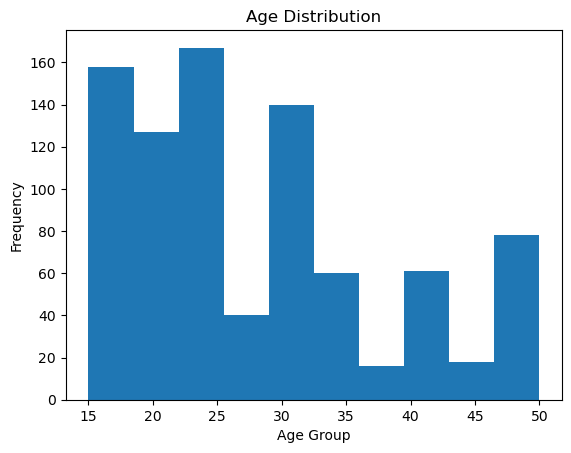

In [7]:
# create histogram
plt.hist(x = "Age", data=df)
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show();

 ### Relationship between Age and Heart Rate by Age Grouping

#### Correlation between Age and Systolic BP

In [8]:
# Calculate the correlation coefficient
correlation = df['Age'].corr(df['SystolicBP'])

# Print the correlation coefficient
print("Correlation coefficient between Age and Systolic BP:", correlation.round(7))

Correlation coefficient between Age and Systolic BP: 0.471852


#### Association Investigation

In [9]:
# create BP values dataframe
df1 = df[['SystolicBP', 'DiastolicBP']]

# Defining the blood pressure categories
high_systolic = df1['SystolicBP'] >= 140
high_diastolic = df1['DiastolicBP'] >= 90
normal_systolic = (df1['SystolicBP'] > 110) & (df1['SystolicBP'] < 140)
normal_diastolic = (df1['DiastolicBP'] > 70) & (df1['DiastolicBP'] < 90)
low_systolic = df1['SystolicBP'] < 110
low_diastolic = df1['DiastolicBP'] < 70

In [10]:
# We need to get the amount of occurences for each blood pressure group category combo, high/high, normal/normal, low/low
hh_count = sum(high_systolic & high_diastolic)
nn_count = sum(normal_systolic & normal_diastolic)
ll_count = sum(low_systolic & low_diastolic)

#calculate the total number of occurences
total_occurences = len(df1)

In [11]:
# Calculating the support for each category combo
support_high_high = hh_count / total_occurences
support_normal_normal = nn_count / total_occurences
support_low_low = ll_count / total_occurences

# Calculating the confidence for each category combo
confidence_high_high = hh_count / sum(high_systolic)
confidence_normal_normal = nn_count / sum(normal_systolic)
confidence_low_low = ll_count / sum(low_systolic)

# Calculate the conviction for each category combo
conviction_high_high = (1 - support_low_low) / (1 - confidence_high_high)
conviction_normal_normal = (1 - support_low_low) / (1 - confidence_normal_normal)
conviction_low_low = (1 - support_high_high) / (1 - confidence_low_low)

# Calculate the lift for each category combination
lift_high_high = confidence_high_high / support_high_high
lift_normal_normal = confidence_normal_normal / support_normal_normal
lift_low_low = confidence_low_low / support_low_low

In [12]:
# Printing the metrics
print("Support (High / High):", support_high_high)
print("Support (Normal / Normal):", support_normal_normal)
print("Support (Low / Low):", support_low_low)
print('\n')
print("Confidence (High / High):", confidence_high_high)
print("Confidence (Normal / Normal):", confidence_normal_normal)
print("Confidence (Low / Low):", confidence_low_low)
print('\n')
print("Conviction (High / High):", conviction_high_high)
print("Conviction (Normal / Normal):", conviction_normal_normal)
print("Conviction (Low / Low):", conviction_low_low)
print('\n')
print("Lift (High / High):", lift_high_high)
print("Lift (Normal / Normal):", lift_normal_normal)
print("Lift (Low / Low):", lift_low_low)

Support (High / High): 0.10751445086705202
Support (Normal / Normal): 0.29364161849710985
Support (Low / Low): 0.23121387283236994


Confidence (High / High): 0.9029126213592233
Confidence (Normal / Normal): 0.5369978858350951
Confidence (Low / Low): 0.7352941176470589


Conviction (High / High): 7.9184971098265935
Conviction (Normal / Normal): 1.6604376171246074
Conviction (Low / Low): 3.3716120745022486


Lift (High / High): 8.398058252427184
Lift (Normal / Normal): 1.828752642706131
Lift (Low / Low): 3.18014705882353


#### Cluster Analysis

C:\Users\ISMAIL\Documents\Github_Folder\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Cluster 0: 162 patients
Cluster 1: 272 patients
Cluster 2: 431 patients


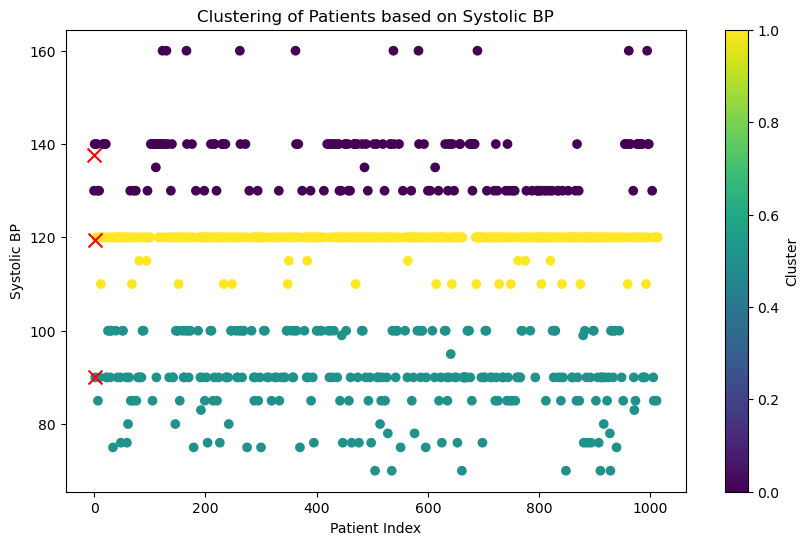

In [13]:
# isolate target variable
systolic_bp = df['SystolicBP'].values.reshape(-1, 1)

# Perform clustering using K-means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(systolic_bp)

# Get the cluster labels assigned to each patient
cluster_labels = kmeans.labels_

# Add the cluster labels to the DataFrame
df['Cluster'] = cluster_labels

# Analyze the clusters
cluster_centers = kmeans.cluster_centers_
# count items in cluster
cluster_sizes = np.bincount(cluster_labels)

# Print the cluster sizes
for i, size in enumerate(cluster_sizes):
    print(f"Cluster {i}: {size} patients")

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['SystolicBP'], c=cluster_labels, cmap='viridis')
plt.scatter(range(3), cluster_centers, c='red', marker='x', s=100)
plt.xlabel('Patient Index')
plt.ylabel('Systolic BP')
plt.title('Clustering of Patients based on Systolic BP')
plt.colorbar(label='Cluster')
plt.show()

In [14]:
df.head()

,Age,SystolicBP,DiastolicBP,Blood Sugar,BodyTemp,HeartRate,RiskLevel,AgeGroup,Cluster
0,25,130,80,15.0,98.0,86,0,17-27,0
1,35,140,90,13.0,98.0,70,0,28-38,0
2,29,90,70,8.0,100.0,80,0,28-38,1
3,30,140,85,7.0,98.0,70,0,28-38,0
4,35,120,60,6.1,98.0,76,1,28-38,2


# Model Creation Without PCA

In [15]:
# declare target variables
target = 'SystolicBP'
X = df.drop(columns=[target, 'AgeGroup','Cluster'])
y = df[target]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_pred_baseline, y_train)
print(f"Mean SystolicBP: {y_mean.round(2)}mmHg")
print(f"Baseline MAE: {baseline_mae.round(2)}mmHg")

model_lr = LinearRegression()

# Fitting the model to the training data
model_lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_lr.predict(X_test)

# calculate test MAE
mae_test = mean_absolute_error(y_pred, y_test)
print("Test MAE: {}".format(round(mae_test, 2)))

# calculate accuracy
accuracy = model_lr.score(X_test, y_test)
print("Test accuracy: {}".format(accuracy))

# Calculate the test_rmse
test_rmse = mean_squared_error(y_test, y_pred) ** (1/2)
print("Test Set RMSE: {}".format(test_rmse))

# Get feature coefficients (importances)
coefficients = model_lr.coef_

# Print feature importances
for i, coefficient in enumerate(coefficients):
    print(f"Feature {i+1}: Importance = {coefficient}")


Mean SystolicBP: 113.59mmHg
Baseline MAE: 15.3mmHg
Test MAE: 8.76
Test accuracy: 0.5991390400505396
Test Set RMSE: 10.712923249284858
Feature 1: Importance = 0.2710440649957531
Feature 2: Importance = 0.890732930578085
Feature 3: Importance = 0.444252172105941
Feature 4: Importance = -0.9203949338017745
Feature 5: Importance = -0.0076569588389478905
Feature 6: Importance = 1.5986592432470943


## Model Creation With PCA 
### Split

In [16]:
# declare target variables
target = 'SystolicBP'
X = df.drop(columns=[target, 'AgeGroup','Cluster'])
y = df[target]

#Apply PCA to reduce the dimensionality of the feature space
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(X)

In [17]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)  

## Build Model 


### Baseline

In [18]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_pred_baseline, y_train)
print(f"Mean SystolicBP: {y_mean.round(2)}mmHg")
print(f"Baseline MAE: {baseline_mae.round(2)}mmHg")

Mean SystolicBP: 113.59mmHg
Baseline MAE: 15.3mmHg


### Iterate

In [19]:
model_lr = LinearRegression()

# Fitting the model to the training data
model_lr.fit(X_train, y_train)

LinearRegression()

### Evaluate

In [20]:
# Make predictions on the test set
y_pred = model_lr.predict(X_test)

# calculate test MAE
mae_test = mean_absolute_error(y_pred, y_test)
print("Test MAE: {}".format(round(mae_test, 2)))

# calculate accuracy
accuracy = model_lr.score(X_test, y_test)
print("Test accuracy: {}".format(accuracy))

# Calculate the test_rmse
test_rmse = mean_squared_error(y_test, y_pred) ** (1/2)
print("Test Set RMSE: {}".format(test_rmse))


Test MAE: 8.79
Test accuracy: 0.5945741859094273
Test Set RMSE: 10.773747951586417


## Communicate

In [21]:


# Get feature coefficients (importances)
coefficients = model_lr.coef_

# Print feature importances
for i, coefficient in enumerate(coefficients):
    print(f"Feature {i+1}: Importance = {coefficient}")



Feature 1: Importance = 0.9525961294888027
Feature 2: Importance = 0.11925307197314845
